<a href="https://colab.research.google.com/github/GavinEBinder/Assignments-Object-Oriented-Programming/blob/main/Final_Project_part2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import statements
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import sklearn as skl, sklearn.datasets as skds
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from functools import partial
from sklearn.metrics import classification_report
from keras import initializers

In [ ]:
# Loading the data
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

In [ ]:
#X_train_full = X_train_full.reshape(X_train_full.shape[0], 32, 32, 3)
#X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
input_shape = (32, 32, 3)

In [ ]:
# normalizing the data to 0-1
X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Normalizing data -1 to 1
'''X_train_full = X_train_full.astype(np.float32)
X_train_full = (X_train_full / 255 - 0.5) * 2
X_train_full = np.clip(X_train_full, -1, 1)

X_test = X_test.astype(np.float32)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)'''

'X_train_full = X_train_full.astype(np.float32)\nX_train_full = (X_train_full / 255 - 0.5) * 2\nX_train_full = np.clip(X_train_full, -1, 1)\n\nX_test = X_test.astype(np.float32)\nX_test = (X_test / 255 - 0.5) * 2\nX_test = np.clip(X_test, -1, 1)'

In [ ]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
# Building the GAN for CIFAR10

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(4*4*512, input_shape=(codings_size,), kernel_initializer="he_normal", activation="relu",),
    tf.keras.layers.Reshape((4, 4, 512)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation='sigmoid'),
])


In [ ]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 batch_normalization_4 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 8, 8, 256)         3277056   
 Transpose)                                                      
                                                                 
 batch_normalization_5 (Bat  (None, 8, 8, 256)         1024      
 chNormalization)                                                
                                                      

In [ ]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", input_shape=[32, 32, 3]),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [ ]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 256)         819456    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 4, 4, 256)         0         
                                                                 
 flatten_2 (Flatten)         (None, 4096)             

In [ ]:
gan = tf.keras.Sequential([generator, discriminator])

In [ ]:
# the discriminator is trainable by itself
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

# the discriminator should not be trained during the second phase
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")
gan.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 32, 32, 3)         4765571   
                                                                 
 sequential_7 (Sequential)   (None, 1)                 1033345   
                                                                 
Total params: 5798916 (22.12 MB)
Trainable params: 4763651 (18.17 MB)
Non-trainable params: 1035265 (3.95 MB)
_________________________________________________________________


In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [ ]:
batch_size = 60
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# repeat the two training phases
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)

            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        # plot images during training
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

In [ ]:
'''noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
print(generated_images)'''

'noise = tf.random.normal(shape=[batch_size, codings_size])\ngenerated_images = generator(noise)\nprint(generated_images)'

Epoch 1/50


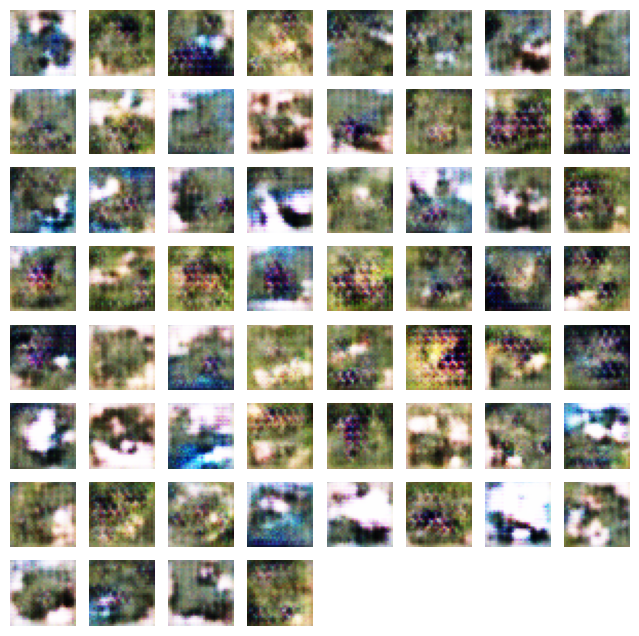

Epoch 2/50


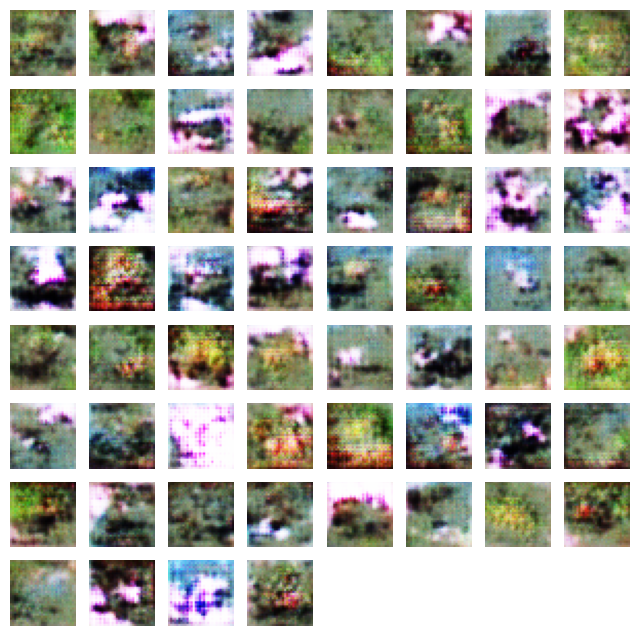

Epoch 3/50


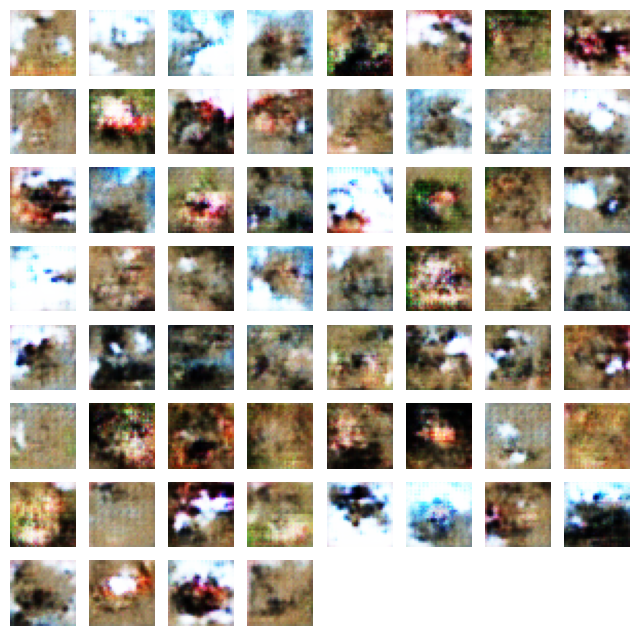

Epoch 4/50


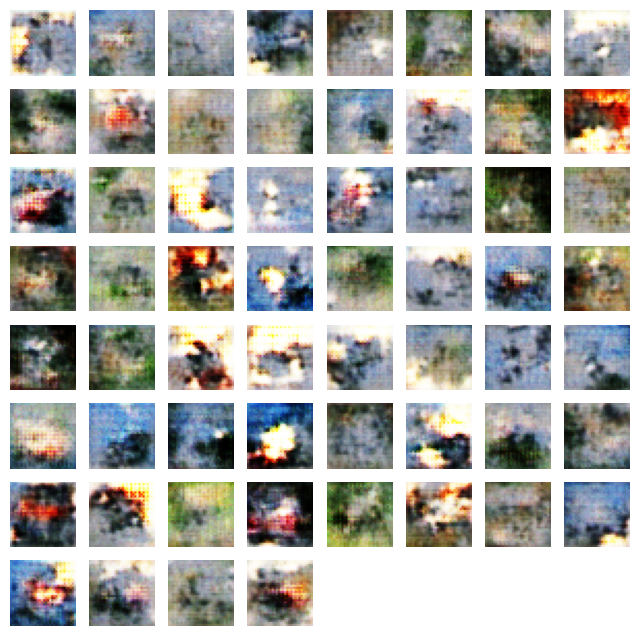

Epoch 5/50


In [ ]:
# 4) train the GAN
train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)